In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
style.use('bmh')

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import plot_confusion_matrix

In [3]:
example = pd.read_csv('predictions_example.csv')
df_train = pd.read_csv('train.csv', )
df_test = pd.read_csv('test.csv')
sites = pd.read_pickle('sites.pkl')
sites = {k:v for v, k in sites.items()}
df_sites = pd.DataFrame({'site': sites.values(), 'id':sites.keys()})

df_test.drop(df_test.columns[0], axis = 1, inplace = True)
df_train.drop(df_train.columns[0], axis = 1, inplace = True)

In [4]:
sites_cols = ['site' + str(i) for i in range(1, 11)]
time_cols = ['time' + str(i) for i in range(1, 11)]
df_time = df_train[[*time_cols, 'target']]
df_sites_names = df_train[sites_cols].astype(float)

for col in df_sites_names.columns:
    df_sites_names[col] = df_sites_names[col].map(sites)
df_sites_names['target'] = df_train['target']

Классы сильно несбалансированы

In [5]:
df_train['target'].value_counts(normalize = True)

0    0.99062
1    0.00938
Name: target, dtype: float64

Для начала переведем все в DateTime и посмотрим на дельты кликов

In [6]:
for i in range(1, 11):
    col = 'time' + str(i)
    df_time[col] = pd.to_datetime(df_time[col], format = '%Y/%m/%d', infer_datetime_format=True)

df_time.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,target
0,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0
1,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT,0
2,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17,0


In [7]:
df_timedeltas = df_time[time_cols].diff(axis = 1).drop('time1', axis = 1)
for col in df_timedeltas.columns:
    df_timedeltas[col] = df_timedeltas[col].dt.total_seconds()
df_timedeltas['target'] = df_train['target']
df_timedeltas.head(3)

,time2,time3,time4,time5,time6,time7,time8,time9,time10,target
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.0,1784.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


<AxesSubplot:xlabel='target'>

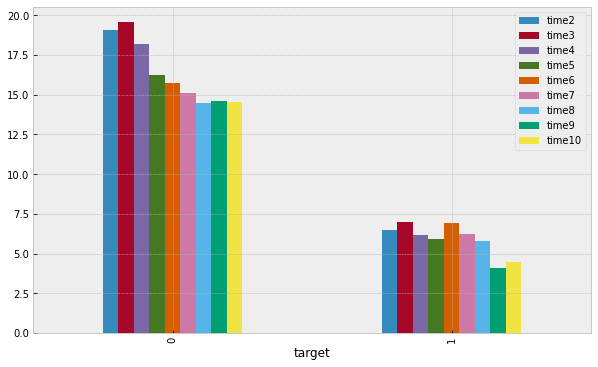

In [8]:
df_timedeltas.groupby('target').mean().plot.bar(figsize = (10, 6))

Даже на глаз видно, что средние у дельт сильно отличаются по группам

In [9]:
def basic_cboost(df, target, cat_features = None, random_seed = 54, silent = True):
    X_train, X_test, y_train, y_test = train_test_split(df,
                                                    target,
                                                    train_size = 0.8,
                                                    random_state = random_seed)

    cboost = CatBoostClassifier(cat_features = cat_features, random_seed = random_seed, silent=silent)
    cboost.fit(X_train, y_train)
    res = {}
    y_pred = cboost.predict(X_test)
    y_proba = cboost.predict_proba(X_test)[:, 1]
    res['model'] = cboost
    res['y_pred'] = y_pred
    res['y_train'] = y_train
    res['probas'] = y_proba
    res['y_test'] = y_test
    res['X_test'] = X_test
    res['X_train'] = X_train
    return res

def show_quality(res_dict):
    print(classification_report(res_dict['y_test'], res_dict['y_pred']))
    print(f"ROC-AUC score: {round(roc_auc_score(res_dict['y_test'], res_dict['probas']), 5)}")
    plot_confusion_matrix(res_dict['model'], res_dict['X_test'], res_dict['y_test']);
    
    

### Модель 1 - Сайты как бинарные признаки (один и тот же/другой) + дельты кликов

In [10]:
df_sites_binary = df_train[sites_cols].diff(axis = 1).iloc[:, 1:] # находим разности по строкам

df_sites_binary = df_sites_binary.applymap(lambda x: -1 if x == np.nan else x)
df_sites_binary = df_sites_binary.applymap(lambda x: 1 if x == 0 else x)
df_sites_binary = df_sites_binary.applymap(lambda x: 0 if (x != 1 and x != -1) else x)

df_v1 = df_timedeltas.join(df_sites_binary, how = 'outer')
df_v1.fillna(-1, inplace = True)
df_v1.drop('target', axis = 1, inplace = True)
target = df_train['target']

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39619
           1       0.00      0.00      0.00       381

    accuracy                           0.99     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.98      0.99      0.99     40000

ROC-AUC score: 0.6844


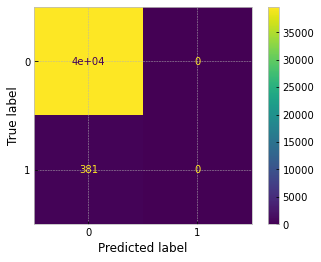

In [11]:
# click deltas + binary sites features (same/not same)
import warnings
warnings.filterwarnings('ignore')

model_1 = basic_cboost(df_v1, target)
show_quality(model_1)

### Модель 2 - Разложение времени (день-час-минута-секунда) + сайты как кат. признаки

In [12]:
df_v2 = df_time.copy()

for i, col in enumerate(time_cols):
    # день недели
    df_v2['day_week_num' + str(i)] = df_v2[col].apply(lambda x: x.dayofweek)
    # час
    df_v2['hour_num' + str(i)] = df_v2[col].apply(lambda x: x.hour)
    # минута
    df_v2['minute_num' + str(i)] = df_v2[col].apply(lambda x: x.minute)
    # секунда
    df_v2['second_num' + str(i)] = df_v2[col].apply(lambda x: x.second)

df_v2.drop(columns=time_cols, inplace=True)
df_v2.drop('target', axis = 1, inplace = True)

In [13]:
df_v2 = df_v2.join(df_train[sites_cols], how = 'outer')
df_v2.fillna(-1, inplace = True)
df_v2[sites_cols] = df_v2[sites_cols].astype(int)

df_v2_cols = [col for col in df_v2.columns if col != 'target']
df_v2_time_cols = [col for col in df_v2_cols if col not in sites_cols]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.84      0.60      0.70       381

    accuracy                           1.00     40000
   macro avg       0.92      0.80      0.85     40000
weighted avg       0.99      1.00      0.99     40000

ROC-AUC score: 0.98926


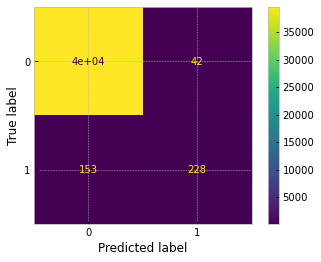

In [14]:
# day+hour+minute+second and sites as cat_features
model_2 = basic_cboost(df_v2, target, cat_features = sites_cols)
show_quality(model_2)

### Модель 3 - Модель 2 + дельты кликов

In [15]:
df_v3 = df_v2.join(df_timedeltas, how = 'outer')
df_v3.drop('target', axis = 1, inplace = True)
df_v3.fillna(-1, inplace = True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.85      0.57      0.69       381

    accuracy                           0.99     40000
   macro avg       0.92      0.79      0.84     40000
weighted avg       0.99      0.99      0.99     40000

ROC-AUC score: 0.98927


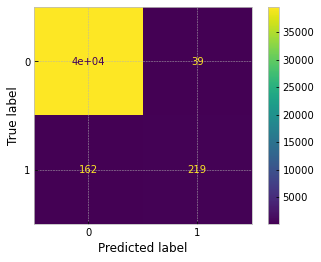

In [16]:
# day+hour+minute+second, click deltas and sites as cat_features
model_3 = basic_cboost(df_v3, target, cat_features = sites_cols)
show_quality(model_3)

### Модель 4 - Модель 3 + Разложение времени (доб. год+месяц+номер недели)

In [12]:
df_v4 = df_time.copy()

for i, col in enumerate(time_cols):
    df_v4['year_num' + str(i)] = df_v4[col].apply(lambda x: x.year)
    df_v4['month_num' + str(i)] = df_v4[col].apply(lambda x: x.month)
    df_v4['week_num' + str(i)] = df_v4[col].apply(lambda x: x.week)
    # день недели
    df_v4['day_week_num' + str(i)] = df_v4[col].apply(lambda x: x.dayofweek)
    # час
    df_v4['hour_num' + str(i)] = df_v4[col].apply(lambda x: x.hour)
    # минута
    df_v4['minute_num' + str(i)] = df_v4[col].apply(lambda x: x.minute)
    # секунда
    df_v4['second_num' + str(i)] = df_v4[col].apply(lambda x: x.second)

df_v4.drop(columns=time_cols, inplace=True)
df_v4.drop('target', axis = 1, inplace = True)

df_v4 = df_v4.join(df_train[sites_cols], how = 'outer')
df_v4.fillna(-1, inplace = True)
df_v4[sites_cols] = df_v4[sites_cols].astype(int)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.93      0.75      0.83       381

    accuracy                           1.00     40000
   macro avg       0.96      0.88      0.92     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99632


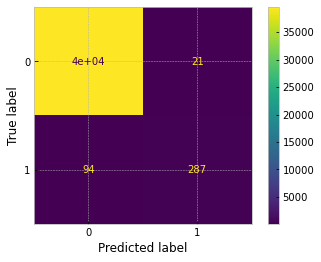

In [18]:
# year+month+week+day+hour+minute+second and sites as cat_features
model_4 = basic_cboost(df_v4, target, cat_features = sites_cols)
show_quality(model_4)

### Модель 5 - Модель 4 + Тип дня (выходной/будний)

In [19]:
df_v5 = df_time.copy()

for i, col in enumerate(time_cols):
    df_v5['year_num' + str(i)] = df_v5[col].apply(lambda x: x.year)
    df_v5['month_num' + str(i)] = df_v5[col].apply(lambda x: x.month)
    df_v5['week_num' + str(i)] = df_v5[col].apply(lambda x: x.week)
    # день недели
    df_v5['day_week_num' + str(i)] = df_v5[col].apply(lambda x: x.dayofweek)
    # выходной/не выходной
    df_v5['day_week_type' + str(i)] = df_v5['day_week_num' + str(i)].apply(lambda x: 0 if x < 5 else x)
    df_v5['day_week_type' + str(i)] = df_v5['day_week_type' + str(i)].apply(lambda x: 1 if x >= 5 else x)
    # час
    df_v5['hour_num' + str(i)] = df_v5[col].apply(lambda x: x.hour)
    # минута
    df_v5['minute_num' + str(i)] = df_v5[col].apply(lambda x: x.minute)
    # секунда
    df_v5['second_num' + str(i)] = df_v5[col].apply(lambda x: x.second)
    
df_v5.drop(columns=time_cols, inplace=True)
df_v5.drop('target', axis = 1, inplace = True)

df_v5 = df_v5.join(df_train[sites_cols], how = 'outer')
df_v5.fillna(-1, inplace = True)
df_v5[sites_cols] = df_v5[sites_cols].astype(int)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.92      0.75      0.82       381

    accuracy                           1.00     40000
   macro avg       0.96      0.87      0.91     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99618


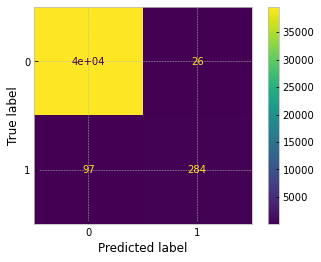

In [20]:
# year+month+week+day+ day type + hour+minute+second and sites as cat_features
model_5 = basic_cboost(df_v5, target, cat_features = sites_cols)
show_quality(model_5)

### Модель 6 -Модель 4 + Длина названия сайта + количество цифр в названии + количество букв в названии

In [21]:
sites[-1] = -1

df_v6 = df_v4.copy()
for site in sites_cols:
    df_v6[site + '_str'] = df_v6[site].map(lambda x: sites[x])
    df_v6[site + '_letter_count'] = df_v6[site + '_str'].map(lambda x: sum(c.isalpha() for c in x) if x!=-1 else x)
    df_v6[site + '_digits_count'] = df_v6[site + '_str'].map(lambda x: sum(c.isdigit() for c in x) if x!=-1 else x)
    df_v6[site + '_total_len'] = df_v6[site + '_str'].map(lambda x: len(x) if x!=-1 else x)
    df_v6.drop(site + '_str', axis = 1, inplace = True)
    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.92      0.73      0.82       381

    accuracy                           1.00     40000
   macro avg       0.96      0.87      0.91     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99491


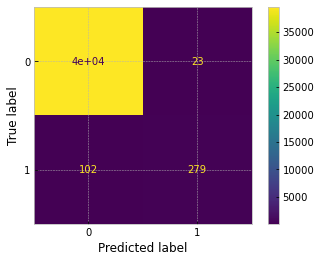

In [22]:
# year+month+week+day+hour+minute+second , sites as cat_features + site name length + number of digits + number of letters
model_6 = basic_cboost(df_v6, target, cat_features = sites_cols)
show_quality(model_6)

## Модель 7 - Модель 6 + Префикс сайта и Доменное имя как кат. признаки

In [23]:
df_v7 = df_v4.copy()
postfix_cols = []
prefix_cols = []
for site in sites_cols:
    df_v7[site + '_str'] = df_v7[site].map(lambda x: sites[x])
    df_v7[site + '_prefix'] = df_v7[site + '_str'].map(lambda x: x.split('.')[0] if x != -1 else x)
    df_v7[site + '_postfix'] = df_v7[site + '_str'].map(lambda x: x.split('.')[-1] if x != -1 else x)
    
    postfix_cols.append(site + '_postfix')
    prefix_cols.append(site + '_prefix')
    
    df_v7[site + '_letter_count'] = df_v7[site + '_str'].map(lambda x: sum(c.isalpha() for c in x) if x!=-1 else x)
    df_v7[site + '_digits_count'] = df_v7[site + '_str'].map(lambda x: sum(c.isdigit() for c in x) if x!=-1 else x)
    df_v7[site + '_total_len'] = df_v7[site + '_str'].map(lambda x: len(x) if x!=-1 else x)
    df_v7.drop(site + '_str', axis = 1, inplace = True)
    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.92      0.70      0.80       381

    accuracy                           1.00     40000
   macro avg       0.96      0.85      0.90     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99338


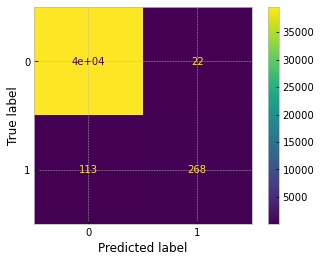

In [24]:
# year+month+week+day+hour+minute+second , sites as cat_features + site name length + number of digits + number of letters + site prefix and postfix as cat_features
model_7 = basic_cboost(df_v7, target, cat_features = sites_cols+postfix_cols+prefix_cols)
show_quality(model_7)

## Модель 8 - Модель 4 + дельта кликов + число цифр в названии + число букв в названии

In [25]:
df_v8 = df_v4.copy()
for site in sites_cols:
    df_v8[site + '_str'] = df_v8[site].map(lambda x: sites[x])
    df_v8[site + '_letter_count'] = df_v8[site + '_str'].map(lambda x: sum(c.isalpha() for c in x) if x!=-1 else x)
    df_v8[site + '_digits_count'] = df_v8[site + '_str'].map(lambda x: sum(c.isdigit() for c in x) if x!=-1 else x)
    df_v8.drop(site + '_str', axis = 1, inplace = True)
    
df_v8 = df_v8.join(df_timedeltas.fillna(-1).drop('target', axis = 1), how = 'outer')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.93      0.73      0.82       381

    accuracy                           1.00     40000
   macro avg       0.97      0.86      0.91     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99598


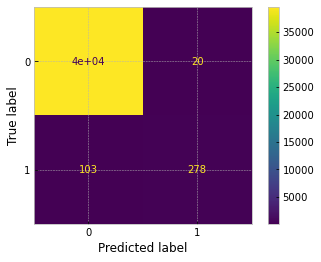

In [26]:
# year+month+week+day+hour+minute+second , click deltas, sites as cat_features  + number of digits + number of letters 
model_8 = basic_cboost(df_v8, target, cat_features = sites_cols)
show_quality(model_8)

## Модель 9 - Модель 4 + дельта кликов

In [27]:
df_v9 = df_v4.copy()
df_v9 = df_v9.join(df_timedeltas.fillna(-1).drop('target', axis = 1), how = 'outer')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.94      0.75      0.83       381

    accuracy                           1.00     40000
   macro avg       0.97      0.87      0.91     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99608


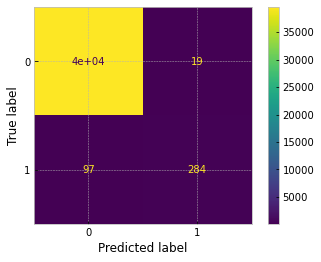

In [28]:
# year+month+week+day+hour+minute+second , click deltas, sites as cat_features
model_9 = basic_cboost(df_v9, target, cat_features = sites_cols)
show_quality(model_9)

## Модель 10 - Модель 4 + средняя дельта кликов

In [29]:
mean_timedeltas = df_timedeltas.drop('target', axis = 1)
mean_timedeltas = mean_timedeltas.apply(lambda x: x.sum()/x.notnull().sum(), axis = 1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.93      0.75      0.83       381

    accuracy                           1.00     40000
   macro avg       0.96      0.88      0.91     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99606


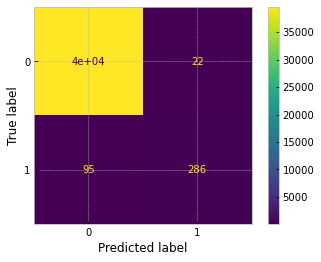

In [30]:
# year+month+week+day+hour+minute+second + mean_click_deltas and sites as cat_features
df_v10 = df_v4.copy()
df_v10['mean_timedeltas'] = mean_timedeltas

model_10 = basic_cboost(df_v10, target, cat_features = sites_cols)
show_quality(model_10)

## Модель 11 - Попытка Tf-Idf (база - Модель 4 )

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfVectorizer

In [32]:
import re
sites_names_raw = [re.split(r"[\W']+", v)  for k,v in sites.items() if v != -1]
sites_names_raw = [item for sublist in sites_names_raw for item in sublist]

In [33]:
sites[-1] = -1
df_train_sites = df_train[sites_cols].fillna(-1).astype(int)
df_train_sites = df_train_sites.applymap(lambda x: sites[x])
df_train_sites = df_train_sites.applymap(lambda x: re.sub(r"[\W']+", ' ', x) if x != -1 else '')

In [34]:
tf_idf = TfidfVectorizer()
tf_idf.fit(sites_names_raw)

TfidfVectorizer()

In [35]:
df_v11 = df_v4.copy()

for site in sites_cols:
    df_tf_idf = tf_idf.transform(df_train_sites[site])
    cols = [site + '_tf_' + str(i) for i in range(df_tf_idf.shape[1])]
    df_v11 = df_v11.join(pd.DataFrame.sparse.from_spmatrix(df_tf_idf, columns = cols), how = 'outer')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.89      0.50      0.64       381

    accuracy                           0.99     40000
   macro avg       0.94      0.75      0.82     40000
weighted avg       0.99      0.99      0.99     40000

ROC-AUC score: 0.97287


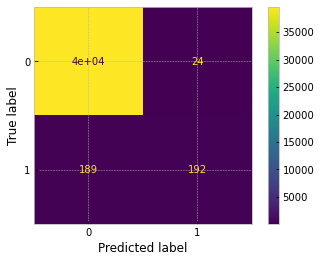

In [36]:
#### year+month+week+day+hour+minute+second + sites as cat_features + tf-tdf features
model_11 = basic_cboost(df_v11, target, cat_features = sites_cols, silent = True)
show_quality(model_11)

Последняя попытка - подозрительность сайтов

## Модель 12 - Модель 4 + подозрительность сайта

In [37]:
df_train_train = model_4['X_train'].copy()
df_train_test = model_4['X_test'].copy()
df_train_train['target'] = model_4['y_train'].copy()
df_train_test['target'] = model_4['y_test'].copy()

In [38]:
suspicious = df_train_train[[*sites_cols, 'target']].fillna(-1).astype(int)

In [39]:
sites[-1] = -1
suspiciousness_rate = {k:0 for k in sites.keys()}
suspects = suspicious[suspicious['target'] == 1]
for i in range(len(suspects)):
    row = suspects.iloc[i]
    for site in row:
        if site != -1:
            suspiciousness_rate[site] += 1

In [40]:
session_suspiciousness_train = df_train_train[sites_cols].applymap(lambda x: suspiciousness_rate[x]).apply(lambda x: sum(x), axis = 1)
session_suspiciousness_test = df_train_test[sites_cols].applymap(lambda x: suspiciousness_rate[x]).apply(lambda x: sum(x), axis = 1)

df_train_train['sus'] = session_suspiciousness_train
df_train_test['sus'] = session_suspiciousness_test

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.94      0.75      0.84       381

    accuracy                           1.00     40000
   macro avg       0.97      0.88      0.92     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99451


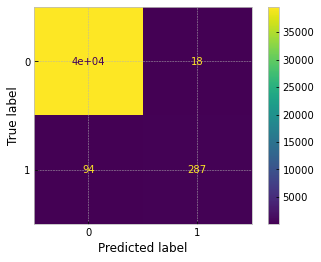

In [41]:
cboost_sus = CatBoostClassifier(cat_features = sites_cols, random_seed = 54, silent=True)
cboost_sus.fit(df_train_train.loc[:, df_train_train.columns != 'target'], df_train_train['target'])
res_sus = {}
y_pred_sus = cboost_sus.predict(df_train_test.loc[:, df_train_test.columns != 'target'])
y_proba_sus = cboost_sus.predict_proba(df_train_test.loc[:, df_train_test.columns != 'target'])[:, 1]
res_sus['model'] = cboost_sus
res_sus['y_pred_sus'] = y_pred_sus
res_sus['probas'] = y_proba_sus
res_sus['y_test'] = df_train_test['target']
res_sus['X_test'] = df_train_test.loc[:, df_train_test.columns != 'target']


print(classification_report(res_sus['y_test'], res_sus['y_pred_sus']))
print(f"ROC-AUC score: {round(roc_auc_score(res_sus['y_test'], res_sus['probas']), 5)}")
plot_confusion_matrix(res_sus['model'], res_sus['X_test'], res_sus['y_test']);

## Поиск по сетке

тут все сложно, во время большого поиска погибло ядро, на GPU и CPU обучение дает разные результаты, тяжело понять, значим ли прирост от поиска или нет. На 100 деревьях сравнивать тоже не очень получается, на дефолтных n_estimators = 1000 результат может получиться хуже, хотя на 100 лучше (это неудивительно на самом деле)


bootstrap_type Bayesian, Bernoulli, Poisson, MVS.
feature_border_type 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.89      0.56      0.69       381

    accuracy                           1.00     40000
   macro avg       0.94      0.78      0.84     40000
weighted avg       0.99      1.00      0.99     40000

ROC-AUC score: 0.98883


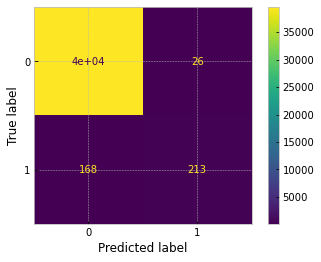

In [42]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = model_4['X_train'], model_4['X_test'], model_4['y_train'], model_4['y_test']
basic_cboost = CatBoostClassifier(n_estimators = 100,
                            cat_features = sites_cols,
                            eval_metric = 'AUC',
                            silent = True,
                            random_state = 54,
                            task_type="GPU")

basic_cboost.fit(X_train_cv, y_train_cv)
y_pred_basic = basic_cboost.predict(X_test_cv)

print(classification_report(y_test_cv, y_pred_basic))
print(f"ROC-AUC score: {round(roc_auc_score(y_test_cv, basic_cboost.predict_proba(X_test_cv)[:,1]), 5)}")
plot_confusion_matrix(basic_cboost, X_test_cv, y_test_cv);
    

In [43]:
cv_boost_1 = CatBoostClassifier(n_estimators = 100,
                            cat_features = sites_cols,
                            eval_metric = 'AUC',
                            silent = True,
                            random_state = 54,
                            task_type="GPU")

In [44]:
param_grid_1 = {
    'depth': np.arange(5,9),
    'l2_leaf_reg' : [2, 3, 4]
#     'max_leaves': np.linspace(10, 50, 5),
#     'min_data_in_leaf' : np.arange(1, 11)
}

In [45]:
cv1 = cv_boost_1.grid_search(param_grid_1,
                     X_train_cv,
                     y = y_train_cv,
                     cv = 3,
                     partition_random_seed=54,
                    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.9252866805
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9252867	best: 0.9252867 (0)	total: 9.65s	remaining: 1m 46s
bestTest = 0.9209133983
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9209134	best: 0.9252867 (0)	total: 19.8s	remaining: 1m 38s
bestTest = 0.92808339
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9280834	best: 0.9280834 (2)	total: 31s	remaining: 1m 33s
bestTest = 0.9324091673
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9324092	best: 0.9324092 (3)	total: 45.3s	remaining: 1m 30s
bestTest = 0.926

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39619
           1       0.94      0.75      0.84       381

    accuracy                           1.00     40000
   macro avg       0.97      0.88      0.92     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC score: 0.99673


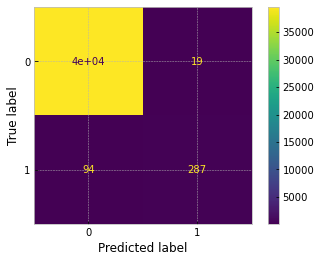

In [46]:
cboost_cv_1 = CatBoostClassifier(n_estimators = 1000,
                            cat_features = sites_cols,
                            eval_metric = 'AUC',
                            silent = True,
                            learning_rate = 0.17,
                            random_state = 54,
                            task_type="CPU")

cboost_cv_1.fit(X_train_cv, y_train_cv)
y_pred_cv_1 = cboost_cv_1.predict(X_test_cv)

print(classification_report(y_test_cv, y_pred_cv_1))
print(f"ROC-AUC score: {round(roc_auc_score(y_test_cv, cboost_cv_1.predict_proba(X_test_cv)[:,1]), 5)}")
plot_confusion_matrix(cboost_cv_1, X_test_cv, y_test_cv);

## Финальная модель

In [128]:
df_final = df_v4
final_model = CatBoostClassifier(n_estimators = 1000,
                            cat_features = sites_cols,
                            eval_metric = 'AUC',
                            silent = True,
                            learning_rate = 0.17,
                            random_state = 54,
                            task_type="CPU")
final_model.fit(df_final, target)

In [129]:
df_sub_time = df_test[time_cols]
for i in range(1, 11):
    col = 'time' + str(i)
    df_sub_time[col] = pd.to_datetime(df_sub_time[col], format = '%Y/%m/%d', infer_datetime_format=True)

In [130]:
df_sub = df_sub_time.copy()

for i, col in enumerate(time_cols):
    df_sub['year_num' + str(i)] = df_sub[col].apply(lambda x: x.year)
    df_sub['month_num' + str(i)] = df_sub[col].apply(lambda x: x.month)
    df_sub['week_num' + str(i)] = df_sub[col].apply(lambda x: x.week)
    # день недели
    df_sub['day_week_num' + str(i)] = df_sub[col].apply(lambda x: x.dayofweek)
    # час
    df_sub['hour_num' + str(i)] = df_sub[col].apply(lambda x: x.hour)
    # минута
    df_sub['minute_num' + str(i)] = df_sub[col].apply(lambda x: x.minute)
    # секунда
    df_sub['second_num' + str(i)] = df_sub[col].apply(lambda x: x.second)

df_sub.drop(columns=time_cols, inplace=True)

df_sub = df_sub.join(df_test[sites_cols], how = 'outer')
df_sub.fillna(-1, inplace = True)
df_sub[sites_cols] = df_sub[sites_cols].astype(int)

In [131]:
sub_probas = final_model.predict_proba(df_sub)[:, 1]
sub_res = pd.DataFrame({'id': example[example.columns[0]],
                        'target': sub_probas})

In [134]:
sub_res.to_csv('Удинский_КТ2.csv', index = False)